# Training labeled satellite imagery to detect fracture patterns

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
from __future__ import print_function

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, f1_score, classification_report

Using TensorFlow backend.


## Get data

In [4]:
# raw image
fracture_data_1 = loadmat('fracture_sample.mat')['frac1unit16']
fracture_data_2 = loadmat('fracture_sample.mat')['frac2unit16']
fracture_data_01 = loadmat('fracture_sample.mat')['nonfrac1unit16']
fracture_data_02 = loadmat('fracture_sample.mat')['nonfrac2unit16']

In [5]:
# labeled image
predicted_data_1 = loadmat('fracture_sample.mat')['frac1_binary']
predicted_data_2 = loadmat('fracture_sample.mat')['frac2_binary']
predicted_data_01 = np.zeros(fracture_data_01.shape)
predicted_data_02 = np.zeros(fracture_data_02.shape)

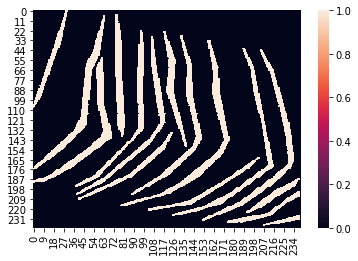

In [6]:
# Plot labeled fracture image (0s and 1s)
predicted_data_02.shape
sns.heatmap(predicted_data_1)

In [7]:
fracture_data_1 = np.pad(fracture_data_1, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))
predicted_data_1 = np.pad(predicted_data_1, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))
fracture_data_2 = np.pad(fracture_data_2, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))
predicted_data_2 = np.pad(predicted_data_2, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))
fracture_data_01 = np.pad(fracture_data_01, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))
predicted_data_01 = np.pad(predicted_data_01, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))
fracture_data_02 = np.pad(fracture_data_02, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))
predicted_data_02 = np.pad(predicted_data_02, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))

In [8]:
# crop image into 3x3 input shape
fracture_data_1 = np.array([fracture_data_1[(y-1):(y+2), (x-1):(x+2)] 
              for x in np.arange(1, fracture_data_1.shape[1] - 1) 
              for y in np.arange(1, fracture_data_1.shape[0] - 1)])

predicted_data_1 = np.array([predicted_data_1[y,x] 
              for x in np.arange(1, predicted_data_1.shape[1] - 1) 
              for y in np.arange(1, predicted_data_1.shape[0] - 1)])

fracture_data_2 = np.array([fracture_data_2[(y-1):(y+2), (x-1):(x+2)] 
              for x in np.arange(1, fracture_data_2.shape[1] - 1) 
              for y in np.arange(1, fracture_data_2.shape[0] - 1)])

predicted_data_2 = np.array([predicted_data_2[y,x] 
              for x in np.arange(1, predicted_data_2.shape[1] - 1) 
              for y in np.arange(1, predicted_data_2.shape[0] - 1)])

fracture_data_01 = np.array([fracture_data_01[(y-1):(y+2), (x-1):(x+2)] 
              for x in np.arange(1, fracture_data_01.shape[1] - 1) 
              for y in np.arange(1, fracture_data_01.shape[0] - 1)])

predicted_data_01 = np.array([predicted_data_01[y,x] 
              for x in np.arange(1, predicted_data_01.shape[1] - 1) 
              for y in np.arange(1, predicted_data_01.shape[0] - 1)])

fracture_data_02 = np.array([fracture_data_02[(y-1):(y+2), (x-1):(x+2)] 
              for x in np.arange(1, fracture_data_02.shape[1] - 1) 
              for y in np.arange(1, fracture_data_02.shape[0] - 1)])

predicted_data_02 = np.array([predicted_data_02[y,x] 
              for x in np.arange(1, predicted_data_02.shape[1] - 1) 
              for y in np.arange(1, predicted_data_02.shape[0] - 1)])

In [10]:
# split 50% of the 3x3 input images into training data, 25% into validation data, 25% into test data 
train_split = int(fracture_data_1.shape[0]/2)
valid_split = int(fracture_data_1.shape[0]*3/4)

fracture_train = np.concatenate((fracture_data_1[:train_split,...],
                           fracture_data_2[:train_split,...],
                           fracture_data_01[:train_split,...],
                           fracture_data_02[:train_split,...]), axis = 0)
fracture_valid = np.concatenate((fracture_data_1[train_split:valid_split,...],
                           fracture_data_2[train_split:valid_split,...],
                           fracture_data_01[train_split:valid_split,...],
                           fracture_data_02[train_split:valid_split,...]), axis = 0)
fracture_test =  np.concatenate((fracture_data_1[valid_split:,...],
                           fracture_data_2[valid_split:,...],
                           fracture_data_01[valid_split:,...],
                           fracture_data_02[valid_split:,...]), axis = 0)

predicted_train = np.concatenate((predicted_data_1[:train_split,...],
                            predicted_data_2[:train_split,...],
                            predicted_data_01[:train_split,...],
                            predicted_data_02[:train_split,...]), axis = 0)
predicted_valid = np.concatenate((predicted_data_1[train_split:valid_split,...],
                            predicted_data_2[train_split:valid_split,...],
                            predicted_data_01[train_split:valid_split,...],
                            predicted_data_02[train_split:valid_split,...]), axis = 0)
predicted_test =  np.concatenate((predicted_data_1[valid_split:,...],
                            predicted_data_2[valid_split:,...],
                            predicted_data_01[valid_split:,...],
                            predicted_data_02[valid_split:,...]), axis = 0)

In [11]:
train_x = np.stack([fracture_train], axis = 3)
train_y = predicted_train

train_x_mean, train_x_std = np.mean(train_x), np.std(train_x)

train_x = (train_x - train_x_mean) / train_x_std

valid_x = np.stack([fracture_valid], axis = 3)
valid_y = predicted_valid

valid_x = (valid_x - train_x_mean) / train_x_std

test_x = np.stack([fracture_test], axis = 3)
test_y = predicted_test

test_x = (test_x - train_x_mean) / train_x_std

In [12]:
fracture_test.shape

(58084, 3, 3)

# A1. Neural Network (NN)
## A1-1. Deep Neural Network

In [13]:
batch_size = 16
epochs = 20

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

model = Sequential()
    
#model.add(Conv2D(64, kernel_size = (3,3), data_format = 'channels_last',
#                     input_shape = train_x.shape[1:], kernel_initializer = 'random_uniform'))
#model.add(Activation('relu'))

model.add(Flatten(input_shape = train_x.shape[1:]))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=SGD(),
              metrics=['acc'])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y))#,
                    #callbacks = callback)#,
                    #class_weight=class_weights)

score = model.evaluate(test_x, test_y, verbose=0)
print(score)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dens

In [14]:
# make prediction on test data
test_y_predict = model.predict(test_x)
test_y_predict = np.array(test_y_predict)

In [19]:
confusion_matrix(test_y, (test_y_predict> 0.3))

array([[49919,  2670],
       [ 2218,  3277]])

In [20]:
f1_score(test_y, (test_y_predict > 0.3))

0.5728019576997029

In [29]:
# Model Performance 
# class 0: non fracture; class 1: fracture;
# precision: % of pixels the model predicts as [class x] are indeed [class x]
# recall: % of pixels that are [class x] were predicted as [class x]
# f1-score: 2*(precision*recall)/(precision + recall)
# support: total # of pixels in [class x]

print(classification_report(test_y, (test_y_predict > 0.32)))  # threshold chosen to be 0.32 to optimize precision/recall

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95     52589
         1.0       0.57      0.58      0.57      5495

   micro avg       0.92      0.92      0.92     58084
   macro avg       0.76      0.77      0.76     58084
weighted avg       0.92      0.92      0.92     58084



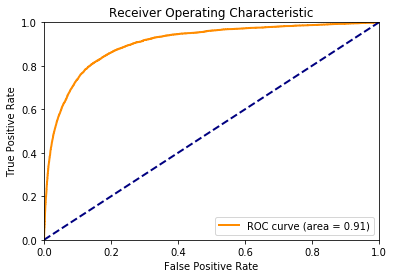

0.9053069080292689


In [22]:
# ROC curve (receiver operating characteristic curve) 
# AUC (Area under the ROC Curve) measures the probability that the model ranks a random positive example 
# more highly than a random negative example

from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print(roc_auc)

In [23]:
test_y_2d = test_y[3:].reshape(241, 241)
test_y_predict_2d = test_y_predict[3:].reshape(241,241)

#test_x_2d = test_x[3:,1,1,0].reshape(241,241)

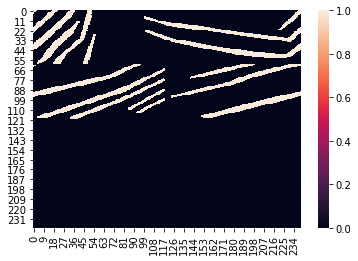

In [24]:
# labeled test data
sns.heatmap(test_y_2d)

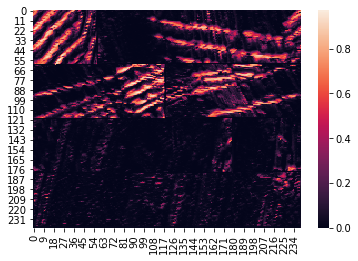

In [25]:
# prediction on test data
sns.heatmap(test_y_predict_2d)

## A1-2. NN with 1 hidden layer

In [13]:
batch_size = 16
epochs = 20

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

model = Sequential()
    
#model.add(Conv2D(64, kernel_size = (3,3), data_format = 'channels_last',
#                     input_shape = train_x.shape[1:], kernel_initializer = 'random_uniform'))
#model.add(Activation('relu'))

model.add(Flatten(input_shape = train_x.shape[1:]))
model.add(Dense(32, activation = 'relu'))
#model.add(Dense(16, activation = 'relu'))
#model.add(Dense(8, activation = 'relu'))
#model.add(Dense(4, activation = 'relu'))
#model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=SGD(),
              metrics=['acc'])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y))#,
                    #callbacks = callback)#,
                    #class_weight=class_weights)

score = model.evaluate(test_x, test_y, verbose=0)
print(score)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 116160 samples, validate on 58080 samples
Epoch 1/20
116160/116160 [==============================] - 5s 39us/step - loss: 0.3113 - acc: 0.8908 - val_loss: 0.3202 - val_acc: 0.8825
Epoch 2/20
116160/116160 [==============================] - 4s 37us/step - loss: 0.2635 - acc: 0.8

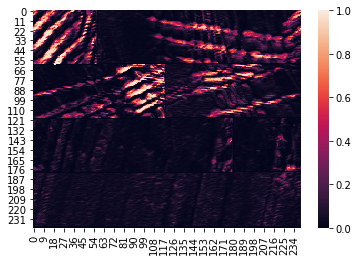

In [15]:
test_y_predict = model.predict(test_x)
test_y_predict = np.array(test_y_predict)
test_y_2d = test_y[3:].reshape(241, 241)
test_y_predict_2d = test_y_predict[3:].reshape(241,241)
sns.heatmap(test_y_predict_2d)

In [19]:
print(classification_report(test_y, (test_y_predict > 0.3)))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     52589
         1.0       0.61      0.52      0.56      5495

   micro avg       0.92      0.92      0.92     58084
   macro avg       0.78      0.74      0.76     58084
weighted avg       0.92      0.92      0.92     58084



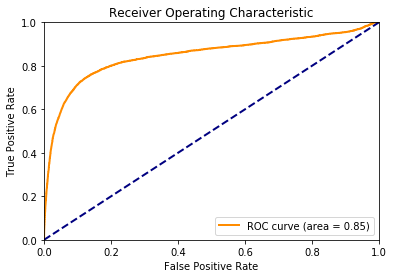

0.8481828396078706


In [17]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print(roc_auc)

## A1-3. Convolutional & Deep NN

In [14]:
batch_size = 16
epochs = 20

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

model = Sequential()
    
model.add(Conv2D(16, kernel_size = (3,3), data_format = 'channels_last',
                     input_shape = train_x.shape[1:], kernel_initializer = 'random_uniform'))
model.add(Activation('relu'))

#model.add(Flatten(input_shape = train_x.shape[1:])) #doesn't matter this or the line below
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=SGD(),
              metrics=['acc'])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y))#,
                    #callbacks = callback)#,
                    #class_weight=class_weights)

score = model.evaluate(test_x, test_y, verbose=0)
print(score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 1, 16)          160       
_________________________________________________________________
activation_2 (Activation)    (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 36        
__________

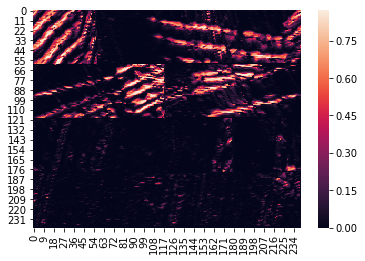

In [15]:
test_y_predict = model.predict(test_x)
test_y_predict = np.array(test_y_predict)
test_y_2d = test_y[3:].reshape(241, 241)
test_y_predict_2d = test_y_predict[3:].reshape(241,241)
sns.heatmap(test_y_predict_2d)

In [18]:
print(classification_report(test_y, (test_y_predict > 0.28)))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     52589
         1.0       0.58      0.57      0.57      5495

   micro avg       0.92      0.92      0.92     58084
   macro avg       0.77      0.76      0.76     58084
weighted avg       0.92      0.92      0.92     58084



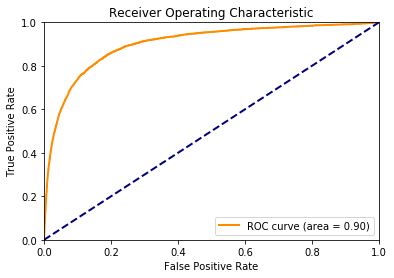

0.9013407177616883


In [17]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print(roc_auc)

# A2. Apply NN model 

In [31]:
#fracture_data_1 = loadmat('fracture_sample.mat')['frac1unit16']
fracture_data_1 = loadmat('moa_125m_2009_1')['moa125m_mask1']
shape = fracture_data_1.shape
#sns.heatmap(fracture_data_1)   #won't work when image is large

fracture_data_1 = np.pad(fracture_data_1, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))

fracture_data_1 = np.array([fracture_data_1[(y-1):(y+2), (x-1):(x+2)] 
              for x in np.arange(1, fracture_data_1.shape[1] - 1) 
              for y in np.arange(1, fracture_data_1.shape[0] - 1)])

train_split = int(fracture_data_1.shape[0]/2)
valid_split = int(fracture_data_1.shape[0]*3/4)

fracture_test =  np.concatenate((fracture_data_1[0:,...],),axis = 0)
test_x = np.stack([fracture_test], axis = 3)
test_x = (test_x - train_x_mean) / train_x_std

y_predict = model.predict(test_x)
y_predict = np.array(y_predict)

In [32]:
print(test_x.shape)
print(y_predict.shape)

(186637608, 3, 3, 1)
(186637608, 1)


In [34]:
# Use for Antarctica image
y_predict_2d = y_predict[0:].reshape(shape[1],shape[0]) #regression result

import scipy.io as sio
# Create a dictionary
dict = {}
dict['y_predict_2d_1'] = y_predict_2d
sio.savemat('testmat.mat', dict)

(58081,)

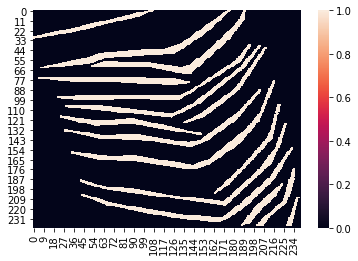

In [29]:
predicted_data_1 = loadmat('fracture_sample.mat')['frac1_binary']
predicted_data_1 = np.pad(predicted_data_1, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))
predicted_data_1 = np.array([predicted_data_1[y,x] 
              for x in np.arange(1, predicted_data_1.shape[1] - 1) 
              for y in np.arange(1, predicted_data_1.shape[0] - 1)])
predicted_test =  predicted_data_1[0:,...]

predict_2d = predicted_test[0:].reshape(241,241) #regression result
sns.heatmap(predict_2d)

predicted_test.shape

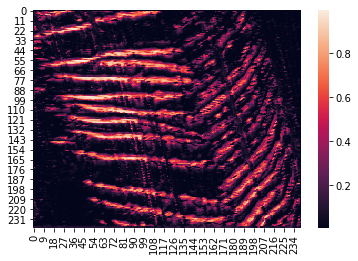

In [30]:
y_predict_2d = y_predict[0:].reshape(241,241) #regression result
sns.heatmap(y_predict_2d)

# B1. Linear Regression (LR)

In [13]:
train_x_flat = train_x.reshape(train_x.shape[0], 9)
valid_x_flat = valid_x.reshape(valid_x.shape[0], 9)
test_x_flat = test_x.reshape(test_x.shape[0], 9)

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
optimal_c = 0.001
loss = 1000

for sub_c in C:
    model = LogisticRegression(C = sub_c).fit(train_x_flat, train_y)
    y_predict = model.predict_proba(valid_x_flat)
    sub_loss = log_loss(valid_y, y_predict)
    if sub_loss < loss:
        loss = sub_loss
        optimal_c = sub_c

model_final = LogisticRegression(C = optimal_c).fit(np.concatenate((train_x_flat, valid_x_flat), axis = 0),
                                                    np.concatenate((train_y, valid_y), axis = 0))
y_predict = model_final.predict_proba(test_x_flat)[:,1]

/home/yao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/yao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/yao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/yao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/yao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

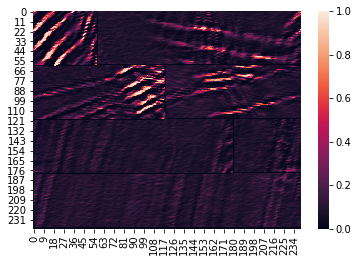

In [16]:
y_predict_2d = y_predict[3:].reshape(241,241) #regression result
sns.heatmap(y_predict_2d)

In [17]:
optimal_c, loss

(1000, 0.31957945385185277)

In [27]:
confusion_matrix(test_y, (y_predict > 0.17))

array([[49871,  2718],
       [ 2612,  2883]])

In [28]:
f1_score(test_y, (y_predict > 0.17))

0.5196467195385726

In [26]:
print(classification_report(test_y, (y_predict > 0.17)))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     52589
         1.0       0.51      0.52      0.52      5495

   micro avg       0.91      0.91      0.91     58084
   macro avg       0.73      0.74      0.73     58084
weighted avg       0.91      0.91      0.91     58084



# B2. Apply LR model

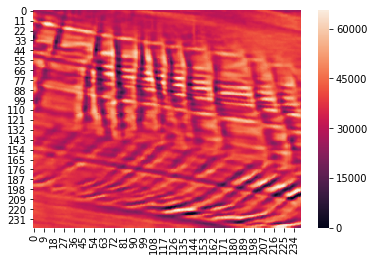

In [83]:
fracture_data_1 = loadmat('fracture_sample.mat')['frac1unit16']
shape = fracture_data_1.shape
sns.heatmap(fracture_data_1)   #won't work when image is large

fracture_data_1 = np.pad(fracture_data_1, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))

fracture_data_1 = np.array([fracture_data_1[(y-1):(y+2), (x-1):(x+2)] 
              for x in np.arange(1, fracture_data_1.shape[1] - 1) 
              for y in np.arange(1, fracture_data_1.shape[0] - 1)])

train_split = int(fracture_data_1.shape[0]/2)
valid_split = int(fracture_data_1.shape[0]*3/4)

fracture_test =  np.concatenate((fracture_data_1[0:,...],),axis = 0)
test_x = np.stack([fracture_test], axis = 3)
test_x = (test_x - train_x_mean) / train_x_std

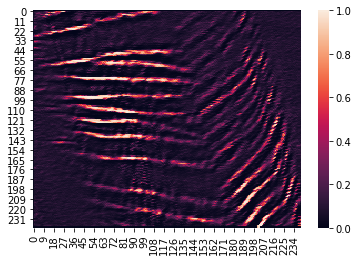

In [84]:
test_x_flat = test_x.reshape(test_x.shape[0], 9)
y_predict_LR = model_final.predict_proba(test_x_flat)[:,1]

y_predict_LR_2d = y_predict_LR[0:].reshape(241,241) #regression result
sns.heatmap(y_predict_LR_2d)